# Multicellular coordination networks

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold
from xgboost import XGBRegressor, DMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import scanpy as sc
import pandas as pd
import networkx as nx
import os

## Load normalized data

In [3]:
features = sc.read_h5ad("../../data/top_features_multi_pT.h5ad")

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Prepare cross-validation

In [4]:
cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv", 
                         index_col = 0)

/tmp/ipykernel_267370/1000358550.py:1: DtypeWarning: Columns (39,40,41,42,43,44,45,46,48,49,52,53,54,55,56,57,58,59,60,61,62,63,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv",


In [5]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

# Only metabolic markers for cancer/epithelial cells
df = cell_table.loc[cell_table.consensus == "Cancer_cell",metab_markers] 
meta = cell_table.loc[cell_table.consensus == "Cancer_cell",["Stage","fov"]]

# A few FOVs show only few epithelial cells and might only add noise to the analysis
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index
df = df.loc[~meta.fov.isin(sparse_epi_fovs)]
meta = meta.loc[~meta.fov.isin(sparse_epi_fovs)]

# Only keep well-annotated stages
epithelial_subset = meta["Stage"].isin(["pT1", "pT2", "pT3", "pT4"]).values

In [6]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)
# For sanity check, the following should consistently be used as validation set
" ".join(fov_val.sort_values())

'A1a A1f A1h A2g A2i A2q A2r A3m A4e A4n A5a A5q A6b A6c A6g A6m A6p A6q A6r A7f A7p A8a A8m A9o A9q B1h B1k B2a B2b B2k B2o B3c B3g B4b B4g B4m B6i B6q B7c B7p B7r B8b B8d B8g B8i B8l B9c B9d B9h B9m B9n B9o C1i C1l C2a C2f C2k C3c C3h C4a C4g C4k C5a C5k C5l C6d C8a C8h D1i D1l D1m D2e D2k D4c D5b D5d D5h D5k D5l D6c D6k D7a D8d D8h'

In [7]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 4
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 4
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


We can split the data at the cell level to allow applications that involve processing single cells. The grouping ensures that the data is split per FOV without contamination (i.e. cells from a given FOV present both in training and testing).

In [8]:
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [9]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov").mean()
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [10]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 4
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


In [11]:
le = LabelEncoder()
le.fit(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"])

LabelEncoder()

## Test prediction

Note on missing values: Some of the samples only had few or none of some cell types, resulting in missing values in the table. Inputation for prediction would not be very helpful, as it is likely that all the values for a cell type are missing for a patient, and thus predictions would be compared to all-inferred values. It seems better to simply exclude these specific patient + cell-type combinations from the respective testing / validation sets.

In [12]:
ref_ctype = "Endothelial_cell"
features_subset = features[meta_per_fov.index[meta_per_fov["inner"]]]
X = features_subset[:,features_subset.var["Cell type"] != ref_ctype].X
Y = features_subset[:,features_subset.var["Cell type"] == ref_ctype].X

In [13]:
# Get the rows of Y that are not NaN
idx_exclude = np.where(np.sum(np.isnan(Y), axis=1))[0]
X = np.delete(X, idx_exclude, 0)
Y = np.delete(Y, idx_exclude, 0)

In [14]:
# Create a mapping from old to new indices after exclusion
valid_indices = np.setdiff1d(np.arange(features_subset.shape[0]),
                             idx_exclude)
old_to_new = {old: new for new, old in enumerate(valid_indices)}

meta_filtered = meta_per_fov.loc[meta_per_fov["inner"]]
meta_filtered = meta_filtered.iloc[valid_indices]

In [15]:
# Also exclude from the CV folds
cv_folds_fov_filtered = []
for train, test in cv_folds_fov:
    # Map old indices to new indices in the filtered array
    train_filtered = np.array([old_to_new[idx] for idx in train if idx not in idx_exclude])
    test_filtered = np.array([old_to_new[idx] for idx in test if idx not in idx_exclude])
    cv_folds_fov_filtered.append((train_filtered, test_filtered))
    
    # All stages should be present in both train and test
    assert len(meta_filtered.iloc[test_filtered]["Stage"].unique()) == 4
    assert len(meta_filtered.iloc[train_filtered]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_filtered.iloc[test_filtered].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


In [16]:
# Visualize how many samples were excluded
print([(x.shape, y.shape) for x, y in cv_folds_fov])
print([(x.shape, y.shape) for x, y in cv_folds_fov_filtered])

[((251,), (83,)), ((249,), (85,)), ((250,), (84,)), ((252,), (82,))]
[((248,), (81,)), ((244,), (85,)), ((247,), (82,)), ((248,), (81,))]


In [17]:
clf = XGBRegressor(eval_metric='aucpr',
                   n_estimators=250, 
                   max_depth=3, 
                   device="cuda", 
                   random_state=0,
                   tree_method="hist")
clf.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='aucpr', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [17]:
scores = cross_val_score(
    XGBRegressor(
                   objective="reg:squarederror",
                   n_estimators=250, 
                   max_depth=3, 
                   device="cuda", 
                   random_state=0,
                   tree_method="hist"),
    X,
    Y,
    cv=cv_folds_fov_filtered,
    scoring="neg_median_absolute_error"
    )
pd.Series(scores).describe()

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:17:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


count    4.000000
mean    -0.338406
std      0.013517
min     -0.353625
25%     -0.343425
50%     -0.339645
75%     -0.334626
max     -0.320710
dtype: float64

In [18]:
scores = cross_val_score(
    XGBRegressor(
                   objective="reg:absoluteerror",
                   n_estimators=250, 
                   max_depth=3, 
                   device="cuda", 
                   random_state=0,
                   tree_method="hist"),
    X,
    Y,
    cv=cv_folds_fov_filtered,
    scoring="neg_median_absolute_error"
    )
pd.Series(scores).describe()

count    4.000000
mean    -0.328119
std      0.019084
min     -0.343438
25%     -0.342822
50%     -0.332954
75%     -0.318251
max     -0.303131
dtype: float64

In [19]:
scores = cross_val_score(
    XGBRegressor(  
                   objective="reg:squarederror",
                   n_estimators=250, 
                   max_depth=3, 
                   random_state=0,
                   tree_method="hist", 
                   multi_strategy="multi_output_tree"),
    X,
    Y,
    cv=cv_folds_fov_filtered,
    scoring="r2"
    )
pd.Series(scores).describe()

count    4.000000
mean     0.426573
std      0.123525
min      0.322536
25%      0.327447
50%      0.402861
75%      0.501987
max      0.578037
dtype: float64

In [20]:
for ctype in features_subset.var["Cell type"].unique():
    Xc = features_subset[:,features_subset.var["Cell type"] == ctype].X
    Xc = np.delete(Xc, idx_exclude, 0)

    scores = cross_val_score(
        XGBRegressor(  
                    objective="reg:squarederror",
                    n_estimators=250, 
                    max_depth=3, 
                    random_state=0,
                    tree_method="hist", 
                    device="cuda", 
                    ),
        Xc,
        Y,
        cv=cv_folds_fov_filtered,
        scoring="r2"
        )
    print(ctype, np.median(scores))

Other_immune_cell -0.026285377425772073
Cytotoxic_lymphocyte -0.09328568029686703
Monocyte 0.30996677203594436
Macrophage 0.13522074662150643
CD4_lymphocyte 0.06153063249703091
Fibroblast 0.1674294354968676
Epithelial_cell -0.07016772753371811
Endothelial_cell 0.9835246257913082


In [21]:
for ctype in features_subset.var["Cell type"].unique():
    Xc = features_subset[:,features_subset.var["Cell type"] == ctype].X
    Xc = np.delete(Xc, idx_exclude, 0)

    scores = cross_val_score(
        XGBRegressor(  
                    objective="reg:absoluteerror",
                    n_estimators=250, 
                    max_depth=3, 
                    random_state=0,
                    tree_method="hist", 
                    device="cuda", 
                    ),
        Xc,
        Y,
        cv=cv_folds_fov_filtered,
        scoring="r2"
        )
    print(ctype, np.median(scores))

Other_immune_cell 0.12045979825590603
Cytotoxic_lymphocyte 0.005800253797540497
Monocyte 0.32541218920159537
Macrophage 0.22804830336143808
CD4_lymphocyte 0.18948982552515498
Fibroblast 0.23820981119505868
Epithelial_cell 0.058496683723314596
Endothelial_cell 0.9775775399800128


In [22]:
for ctype in features_subset.var["Cell type"].unique():
    Xc = features_subset[:,features_subset.var["Cell type"] == ctype].X
    Xc = np.delete(Xc, idx_exclude, 0)

    scores = cross_val_score(
        XGBRegressor(  
                    objective="reg:squarederror",
                    n_estimators=250, 
                    max_depth=3, 
                    random_state=0,
                    tree_method="hist", 
                    multi_strategy="multi_output_tree"),
        Xc,
        Y,
        cv=cv_folds_fov_filtered,
        scoring="r2"
        )
    print(ctype, np.median(scores))

Other_immune_cell -0.003223976731088384
Cytotoxic_lymphocyte -0.07120406058242693
Monocyte 0.29942895320445984
Macrophage 0.2406432040946755
CD4_lymphocyte 0.0969169430403305
Fibroblast 0.15103715082720565
Epithelial_cell -0.0323703153952556
Endothelial_cell 0.9409882434648837


In [23]:
for ref_ctype in features_subset.var["Cell type"].unique():
    features_subset = features[meta_per_fov.index[meta_per_fov["inner"]]]
    X = features_subset[:,features_subset.var["Cell type"] != ref_ctype].X
    Y = features_subset[:,features_subset.var["Cell type"] == ref_ctype].X

    # Get the rows of Y that are not NaN
    idx_exclude = np.where(np.sum(np.isnan(Y), axis=1))[0]
    X = np.delete(X, idx_exclude, 0)
    Y = np.delete(Y, idx_exclude, 0)

    # Create a mapping from old to new indices after exclusion
    valid_indices = np.setdiff1d(np.arange(features_subset.shape[0]),
                                idx_exclude)
    old_to_new = {old: new for new, old in enumerate(valid_indices)}

    meta_filtered = meta_per_fov.loc[meta_per_fov["inner"]]
    meta_filtered = meta_filtered.iloc[valid_indices]

    # Also exclude from the CV folds
    cv_folds_fov_filtered = []
    for train, test in cv_folds_fov:
        # Map old indices to new indices in the filtered array
        train_filtered = np.array([old_to_new[idx] for idx in train if idx not in idx_exclude])
        test_filtered = np.array([old_to_new[idx] for idx in test if idx not in idx_exclude])
        cv_folds_fov_filtered.append((train_filtered, test_filtered))
        
        # All stages should be present in both train and test
        assert len(meta_filtered.iloc[test_filtered]["Stage"].unique()) == 4
        assert len(meta_filtered.iloc[train_filtered]["Stage"].unique()) == 4
        # Print the first test FOVs
        # print(meta_filtered.iloc[test_filtered].index[:5])

    for ctype in features_subset.var["Cell type"].unique():
        Xc = features_subset[:,features_subset.var["Cell type"] == ctype].X
        Xc = np.delete(Xc, idx_exclude, 0)

        scores = cross_val_score(
            XGBRegressor(  
                        objective="reg:squarederror",
                        n_estimators=250, 
                        max_depth=3, 
                        random_state=0,
                        tree_method="hist", 
                        multi_strategy="multi_output_tree"),
            Xc,
            Y,
            cv=cv_folds_fov_filtered,
            scoring="r2"
            )
        if (np.median(scores) > 0.15) and (ref_ctype != ctype):
            print(ref_ctype, ctype, np.median(scores))

Other_immune_cell Cytotoxic_lymphocyte 0.17663596085127065
Other_immune_cell Monocyte 0.3404049227642107
Cytotoxic_lymphocyte Monocyte 0.2211446979777344
Cytotoxic_lymphocyte CD4_lymphocyte 0.1541429377649608
Monocyte Other_immune_cell 0.2703410070724866
Monocyte Macrophage 0.26550744662903625
Monocyte CD4_lymphocyte 0.17244383953232856
Macrophage Monocyte 0.2692028294393376
Macrophage CD4_lymphocyte 0.2707719965383193
Macrophage Fibroblast 0.2175800649735271
Macrophage Endothelial_cell 0.18238073552287476
CD4_lymphocyte Monocyte 0.22531899379229808
CD4_lymphocyte Macrophage 0.19438764840151104
Endothelial_cell Monocyte 0.29942895320445984
Endothelial_cell Macrophage 0.2406432040946755
Endothelial_cell Fibroblast 0.15103715082720565


In [24]:
for ref_ctype in features_subset.var["Cell type"].unique():
    features_subset = features[meta_per_fov.index[meta_per_fov["inner"]]]
    X = features_subset[:,features_subset.var["Cell type"] != ref_ctype].X
    Y = features_subset[:,features_subset.var["Cell type"] == ref_ctype].X

    # Get the rows of Y that are not NaN
    idx_exclude = np.where(np.sum(np.isnan(Y), axis=1))[0]
    X = np.delete(X, idx_exclude, 0)
    Y = np.delete(Y, idx_exclude, 0)

    # Create a mapping from old to new indices after exclusion
    valid_indices = np.setdiff1d(np.arange(features_subset.shape[0]),
                                idx_exclude)
    old_to_new = {old: new for new, old in enumerate(valid_indices)}

    meta_filtered = meta_per_fov.loc[meta_per_fov["inner"]]
    meta_filtered = meta_filtered.iloc[valid_indices]

    # Also exclude from the CV folds
    cv_folds_fov_filtered = []
    for train, test in cv_folds_fov:
        # Map old indices to new indices in the filtered array
        train_filtered = np.array([old_to_new[idx] for idx in train if idx not in idx_exclude])
        test_filtered = np.array([old_to_new[idx] for idx in test if idx not in idx_exclude])
        cv_folds_fov_filtered.append((train_filtered, test_filtered))
        
        # All stages should be present in both train and test
        assert len(meta_filtered.iloc[test_filtered]["Stage"].unique()) == 4
        assert len(meta_filtered.iloc[train_filtered]["Stage"].unique()) == 4
        # Print the first test FOVs
        # print(meta_filtered.iloc[test_filtered].index[:5])

    for ctype in features_subset.var["Cell type"].unique():
        Xc = features_subset[:,features_subset.var["Cell type"] == ctype].X
        Xc = np.delete(Xc, idx_exclude, 0)

        scores = cross_val_score(
            XGBRegressor(  
                        objective="reg:squarederror",
                        n_estimators=250, 
                        max_depth=3, 
                        random_state=0,
                        tree_method="hist", 
                        device="cuda"),
            Xc,
            Y,
            cv=cv_folds_fov_filtered,
            scoring="r2"
            )
        if (np.median(scores) > 0.15) and (ref_ctype != ctype):
            print(ref_ctype, ctype, np.median(scores))

Other_immune_cell Monocyte 0.2548848178953697
Cytotoxic_lymphocyte Monocyte 0.1677145096329406
Cytotoxic_lymphocyte CD4_lymphocyte 0.1544900140978066
Monocyte Other_immune_cell 0.29027794107524374
Monocyte Macrophage 0.22898677480938234
Monocyte CD4_lymphocyte 0.1720921596600492
Macrophage Monocyte 0.2877490155149487
Macrophage CD4_lymphocyte 0.2575581449223299
Macrophage Fibroblast 0.19573940185899563
Macrophage Endothelial_cell 0.16223489931509416
CD4_lymphocyte Monocyte 0.20148265888938122
CD4_lymphocyte Macrophage 0.1702553757094155
Endothelial_cell Monocyte 0.30996677203594436
Endothelial_cell Fibroblast 0.1674294354968676


In [25]:
for ref_ctype in features_subset.var["Cell type"].unique():
    features_subset = features[meta_per_fov.index[meta_per_fov["inner"]]]
    X = features_subset[:,features_subset.var["Cell type"] != ref_ctype].X
    Y = features_subset[:,features_subset.var["Cell type"] == ref_ctype].X

    # Get the rows of Y that are not NaN
    idx_exclude = np.where(np.sum(np.isnan(Y), axis=1))[0]
    X = np.delete(X, idx_exclude, 0)
    Y = np.delete(Y, idx_exclude, 0)

    # Create a mapping from old to new indices after exclusion
    valid_indices = np.setdiff1d(np.arange(features_subset.shape[0]),
                                idx_exclude)
    old_to_new = {old: new for new, old in enumerate(valid_indices)}

    meta_filtered = meta_per_fov.loc[meta_per_fov["inner"]]
    meta_filtered = meta_filtered.iloc[valid_indices]

    # Also exclude from the CV folds
    cv_folds_fov_filtered = []
    for train, test in cv_folds_fov:
        # Map old indices to new indices in the filtered array
        train_filtered = np.array([old_to_new[idx] for idx in train if idx not in idx_exclude])
        test_filtered = np.array([old_to_new[idx] for idx in test if idx not in idx_exclude])
        cv_folds_fov_filtered.append((train_filtered, test_filtered))
        
        # All stages should be present in both train and test
        assert len(meta_filtered.iloc[test_filtered]["Stage"].unique()) == 4
        assert len(meta_filtered.iloc[train_filtered]["Stage"].unique()) == 4
        # Print the first test FOVs
        # print(meta_filtered.iloc[test_filtered].index[:5])

    for ctype in features_subset.var["Cell type"].unique():
        Xc = features_subset[:,features_subset.var["Cell type"] == ctype].X
        Xc = np.delete(Xc, idx_exclude, 0)

        scores = cross_val_score(
            XGBRegressor(  
                        objective="reg:absoluteerror",
                        n_estimators=250, 
                        max_depth=3, 
                        random_state=0,
                        tree_method="hist", 
                        device="cuda"),
            Xc,
            Y,
            cv=cv_folds_fov_filtered,
            scoring="r2"
            )
        if (np.median(scores) > 0.15) and (ref_ctype != ctype):
            print(ref_ctype, ctype, np.median(scores))

Other_immune_cell Monocyte 0.3598984039177644
Other_immune_cell Macrophage 0.17172134600297825
Cytotoxic_lymphocyte Monocyte 0.2536385860937797
Cytotoxic_lymphocyte Macrophage 0.160927949930974
Monocyte Other_immune_cell 0.33782628138131116
Monocyte Macrophage 0.272849835217124
Monocyte CD4_lymphocyte 0.2483969717091256
Monocyte Endothelial_cell 0.15636444790113088
Macrophage Cytotoxic_lymphocyte 0.18236862063462703
Macrophage Monocyte 0.3042166336126024
Macrophage CD4_lymphocyte 0.2547573883542256
Macrophage Fibroblast 0.27988378062516195
Macrophage Endothelial_cell 0.30157416843208207
CD4_lymphocyte Monocyte 0.2570655378904642
CD4_lymphocyte Macrophage 0.2622689651720127
CD4_lymphocyte Fibroblast 0.18809990247770356
Endothelial_cell Monocyte 0.32541218920159537
Endothelial_cell Macrophage 0.22804830336143808
Endothelial_cell CD4_lymphocyte 0.18948982552515498
Endothelial_cell Fibroblast 0.23820981119505868


## Main model selection loop

In [16]:
def process_fold(X, Y, train, test, n_estimators = 250, n_depth = 3):
    # logging.getLogger('tensorflow').setLevel(logging.ERROR)
    # with warnings.catch_warnings(action="ignore"):      
    # Step 1: Define train and test subsets of the compositional data
    train_func = X[train]
    test_func = X[test]
    train_meta = Y[train]
    test_meta = Y[test]

    # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
    xgb = XGBRegressor(  
                    objective="reg:absoluteerror",
                    n_estimators=n_estimators, 
                    max_depth=n_depth, 
                    random_state=0,
                    tree_method="hist", 
                    verbosity = 0,
                    device="cuda")
    xgb.fit(train_func,
            train_meta)

    # Step 3: Predict stage of each FOV in the test data
    preds = xgb.predict(test_func)

    # Step 4: Compute f1_score
    score = r2_score(test_meta, 
                    preds)
    return score

In [17]:
def test_parameters(X, Y, cv_folds, file_path, estimators, depth, verbose = False):
    scores = [0 for _ in cv_folds]
    for i, (train, test) in enumerate(cv_folds):
        scores[i] = process_fold(X, Y, train, test, n_estimators=estimators, n_depth=depth)
        if scores[i] <= 0:
            if verbose:
                print("Bad performance, skipping.", file_path, estimators, depth)
            return -1
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(file_path, "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    if verbose:
        print(file_path, estimators, depth, mean_score)
    return mean_score

In [28]:
process_fold(Xc, Y, train_filtered, test_filtered)

0.9940949336213796

In [29]:
test_parameters(Xc, Y, cv_folds_fov_filtered, "../../data/ignoreme.txt", estimators = 250, depth = 3, verbose = True)

../../data/ignoreme.txt 250 3 0.9775775399800128


0.9775775399800128

In [18]:
from joblib import Parallel, delayed
import warnings, logging
from time import ctime

In [19]:
def test_celltype_pair(ref_ctype, query_ctype):
    X = features_subset[:,features_subset.var["Cell type"] != ref_ctype].X
    Y = features_subset[:,features_subset.var["Cell type"] == ref_ctype].X

    # Get the rows of Y that are not NaN
    idx_exclude = np.where(np.sum(np.isnan(Y), axis=1))[0]
    X = np.delete(X, idx_exclude, 0)
    Y = np.delete(Y, idx_exclude, 0)

    # Create a mapping from old to new indices after exclusion
    valid_indices = np.setdiff1d(np.arange(features_subset.shape[0]),
                                idx_exclude)
    old_to_new = {old: new for new, old in enumerate(valid_indices)}

    meta_filtered = meta_per_fov.loc[meta_per_fov["inner"]]
    meta_filtered = meta_filtered.iloc[valid_indices]

    # Also exclude from the CV folds
    cv_folds_fov_filtered = []
    for train, test in cv_folds_fov:
        # Map old indices to new indices in the filtered array
        train_filtered = np.array([old_to_new[idx] for idx in train if idx not in idx_exclude])
        test_filtered = np.array([old_to_new[idx] for idx in test if idx not in idx_exclude])
        cv_folds_fov_filtered.append((train_filtered, test_filtered))
        
        # All stages should be present in both train and test
        assert len(meta_filtered.iloc[test_filtered]["Stage"].unique()) == 4
        assert len(meta_filtered.iloc[train_filtered]["Stage"].unique()) == 4

    Xc = features_subset[:,features_subset.var["Cell type"] == query_ctype].X
    Xc = np.delete(Xc, idx_exclude, 0)

    # Loop over parameters
    estimator_range = np.arange(15, 511, 10)
    depth_range = depth_range = [2,3,4,5]
    estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
    Parallel(n_jobs=28)(delayed(test_parameters)(
                    Xc,
                    Y, 
                    cv_folds_fov_filtered, 
                    f"../../data/model_celltypes_{ref_ctype}_{query_ctype}.csv",
                     estimators = r_estimators, depth = r_depth, 
                     verbose = False)
                    for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))
    

In [ ]:
# Computed in previous runs
skipped_pairs = [
# "Other_immune_cell_CD4_lymphocyte", 
# "Other_immune_cell_Cytotoxic_lymphocyte", 
# "Other_immune_cell_Fibroblast", 
# "Other_immune_cell_Monocyte", 
# "Other_immune_cell_Macrophage",
]

for c1 in features.var["Cell type"].unique():
    for c2 in features.var["Cell type"].unique():
        if (c1 != c2) and (f"{c1}_{c2}" not in skipped_pairs):
            print(f"{ctime()} – Testing {c1} vs {c2}")
            test_celltype_pair(c1, c2)

Thu Aug 14 12:26:10 2025 – Testing Other_immune_cell vs Cytotoxic_lymphocyte


## Validate best model for each pair

In [20]:
def validate_celltype_pair(ref_ctype, query_ctype, max_depth, max_estimators):
    X_train = features[meta_per_fov.index[meta_per_fov["inner"]],
                   features_subset.var["Cell type"] == query_ctype]
    Y_train = features[meta_per_fov.index[meta_per_fov["inner"]],
                    features_subset.var["Cell type"] == ref_ctype]
    
    # Get the rows of Y_train that are not NaN
    idx_exclude = np.where(np.sum(np.isnan(Y_train.X), axis=1))[0]
    X_train = np.delete(X_train.X, idx_exclude, 0)
    Y_train = np.delete(Y_train.X, idx_exclude, 0)

    # Prepare validation data
    X_val = features[meta_per_fov.index[~meta_per_fov["inner"]], 
                     features.var["Cell type"] == query_ctype].X
    Y_val = features[meta_per_fov.index[~meta_per_fov["inner"]], 
                     features.var["Cell type"] == ref_ctype].X
    
    # Exclude rows with NaN in Y_val
    idx_exclude_val = np.where(np.sum(np.isnan(Y_val), axis=1))[0]
    X_val = np.delete(X_val, idx_exclude_val, 0)
    Y_val = np.delete(Y_val, idx_exclude_val, 0)

    xgb = XGBRegressor(  
                    objective="reg:absoluteerror",
                    n_estimators=max_estimators, 
                    max_depth=max_depth, 
                    random_state=0,
                    tree_method="hist", 
                    device="cuda")
    xgb.fit(X_train,
            Y_train)

    # Predict stage of each FOV in the validation data
    preds = xgb.predict(X_val)

    # Compute r2 score
    score = r2_score(Y_val, 
                    preds)
    return score

In [21]:
def validate_celltype_pair_stage_strafied(ref_ctype, query_ctype, max_depth, max_estimators):
    X_train = features[meta_per_fov.index[meta_per_fov["inner"]],
                   features_subset.var["Cell type"] == query_ctype]
    Y_train = features[meta_per_fov.index[meta_per_fov["inner"]],
                    features_subset.var["Cell type"] == ref_ctype]
    
    # Get the rows of Y_train that are not NaN
    idx_exclude = np.where(np.sum(np.isnan(Y_train.X), axis=1))[0]
    X_train = np.delete(X_train.X, idx_exclude, 0)
    Y_train = np.delete(Y_train.X, idx_exclude, 0)

    # Prepare validation data
    X_val = features[meta_per_fov.index[~meta_per_fov["inner"]], 
                     features.var["Cell type"] == query_ctype].X
    Y_val = features[meta_per_fov.index[~meta_per_fov["inner"]], 
                     features.var["Cell type"] == ref_ctype].X
    
    # Exclude rows with NaN in Y_val
    idx_exclude_val = np.where(np.sum(np.isnan(Y_val), axis=1))[0]
    X_val = np.delete(X_val, idx_exclude_val, 0)
    Y_val = np.delete(Y_val, idx_exclude_val, 0)

    xgb = XGBRegressor(  
                    objective="reg:absoluteerror",
                    n_estimators=max_estimators, 
                    max_depth=max_depth, 
                    random_state=0,
                    tree_method="hist", 
                    device="cuda")
    xgb.fit(X_train,
            Y_train)

    # Predict stage of each FOV in the validation data
    preds = xgb.predict(X_val)

    # Compute r2 score
    score = r2_score(Y_val, 
                    preds)

    # Update meta for selected validation set
    meta_val = meta_per_fov.loc[~meta_per_fov["inner"]]
    
    if len(idx_exclude_val):
        meta_val = meta_val.drop(meta_val.index[idx_exclude_val])

    # Validation on ealy stages only
    X_early = X_val[meta_val["Stage"].isin(["pT1", "pT2"])]
    Y_early = Y_val[meta_val["Stage"].isin(["pT1", "pT2"])]

    preds_early = xgb.predict(X_early)
    score_early = r2_score(Y_early, 
                           preds_early)
    
    # Validation on late stages only
    X_late = X_val[meta_val["Stage"].isin(["pT3", "pT4"])]
    Y_late = Y_val[meta_val["Stage"].isin(["pT3", "pT4"])]

    preds_late = xgb.predict(X_late)
    score_late = r2_score(Y_late, 
                          preds_late)
    
    return score, score_early, score_late

In [22]:
data_files = os.listdir("../../data")
r2_threshold = 0.2 # Ignore models with low performance on CV inner folds

# Create a directed weighted graph to store the predictability between feature types
pred_network = nx.DiGraph()
pred_network_early = nx.DiGraph()
pred_network_late = nx.DiGraph()

for c1 in features.var["Cell type"].unique():
    for c2 in features.var["Cell type"].unique():
        model_file = f"model_celltypes_{c1}_{c2}.csv"
        # Some pairs were skipped due to bad performance
        if model_file in data_files:
            pairformance = pd.read_csv(f"../../data/{model_file}", header=None, 
                                       names=["n_estimators", "max_depth", "mean_r2_score"])
            pairformance = pairformance.sort_values("mean_r2_score", ascending=False)
            best_model = pairformance.iloc[0]
            print(f"Best model for {c1} vs {c2}: n_estimators = {best_model['n_estimators']}, "
                  f"max_depth = {best_model['max_depth']}, "
                  f"median r2 score = {best_model['mean_r2_score']:.4f}")
            if best_model['mean_r2_score'] > r2_threshold:
                # Validate the best model on the outer validation set
                scores = validate_celltype_pair_stage_strafied(c1, c2,
                                                  int(best_model['max_depth']),
                                                  int(best_model['n_estimators']))
                print(f"Validation r2 score for {c1} vs {c2}: {scores[0]:.4f}")
                if scores[0] > r2_threshold:
                    # Add an edge to the graph with the r2 score as weight
                    pred_network.add_edge(c2, c1, weight=scores[0]) # C2 predicts C1
                if scores[1] > r2_threshold:
                    # Add an edge to the early stages graph with the r2 score as weight
                    pred_network_early.add_edge(c2, c1, weight=scores[1])
                if scores[2] > r2_threshold:
                    # Add an edge to the late stages graph with the r2 score as weight
                    pred_network_late.add_edge(c2, c1, weight=scores[2])

# Save the networks to a GML files
nx.write_gml(pred_network, "../../data/celltype_graph.gml")
nx.write_gml(pred_network_early, "../../data/celltype_graph_early.gml")
nx.write_gml(pred_network_late, "../../data/celltype_graph_late.gml")

Best model for Other_immune_cell vs Cytotoxic_lymphocyte: n_estimators = 15.0, max_depth = 3.0, median r2 score = 0.1723
Best model for Other_immune_cell vs Monocyte: n_estimators = 65.0, max_depth = 3.0, median r2 score = 0.3869


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:16:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation r2 score for Other_immune_cell vs Monocyte: 0.4269
Best model for Other_immune_cell vs CD4_lymphocyte: n_estimators = 25.0, max_depth = 3.0, median r2 score = 0.1311
Best model for Other_immune_cell vs Fibroblast: n_estimators = 15.0, max_depth = 3.0, median r2 score = 0.0891
Best model for Other_immune_cell vs Epithelial_cell: n_estimators = 15.0, max_depth = 3.0, median r2 score = 0.1442
Best model for Other_immune_cell vs Endothelial_cell: n_estimators = 15.0, max_depth = 3.0, median r2 score = 0.1492
Best model for Cytotoxic_lymphocyte vs Other_immune_cell: n_estimators = 15.0, max_depth = 3.0, median r2 score = 0.2073
Validation r2 score for Cytotoxic_lymphocyte vs Other_immune_cell: 0.2978
Best model for Cytotoxic_lymphocyte vs Monocyte: n_estimators = 15.0, max_depth = 3.0, median r2 score = 0.3253
Validation r2 score for Cytotoxic_lymphocyte vs Monocyte: 0.3488
Best model for Cytotoxic_lymphocyte vs CD4_lymphocyte: n_estimators = 15.0, max_depth = 3.0, median r2 scor

## Correlation map

In [46]:
# Compute Spearman correlation coefficient
cordf = pd.DataFrame(features.X, 
                     columns=features.var.Variable).corr(method='spearman')

/tmp/ipykernel_267370/2081284698.py:59: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


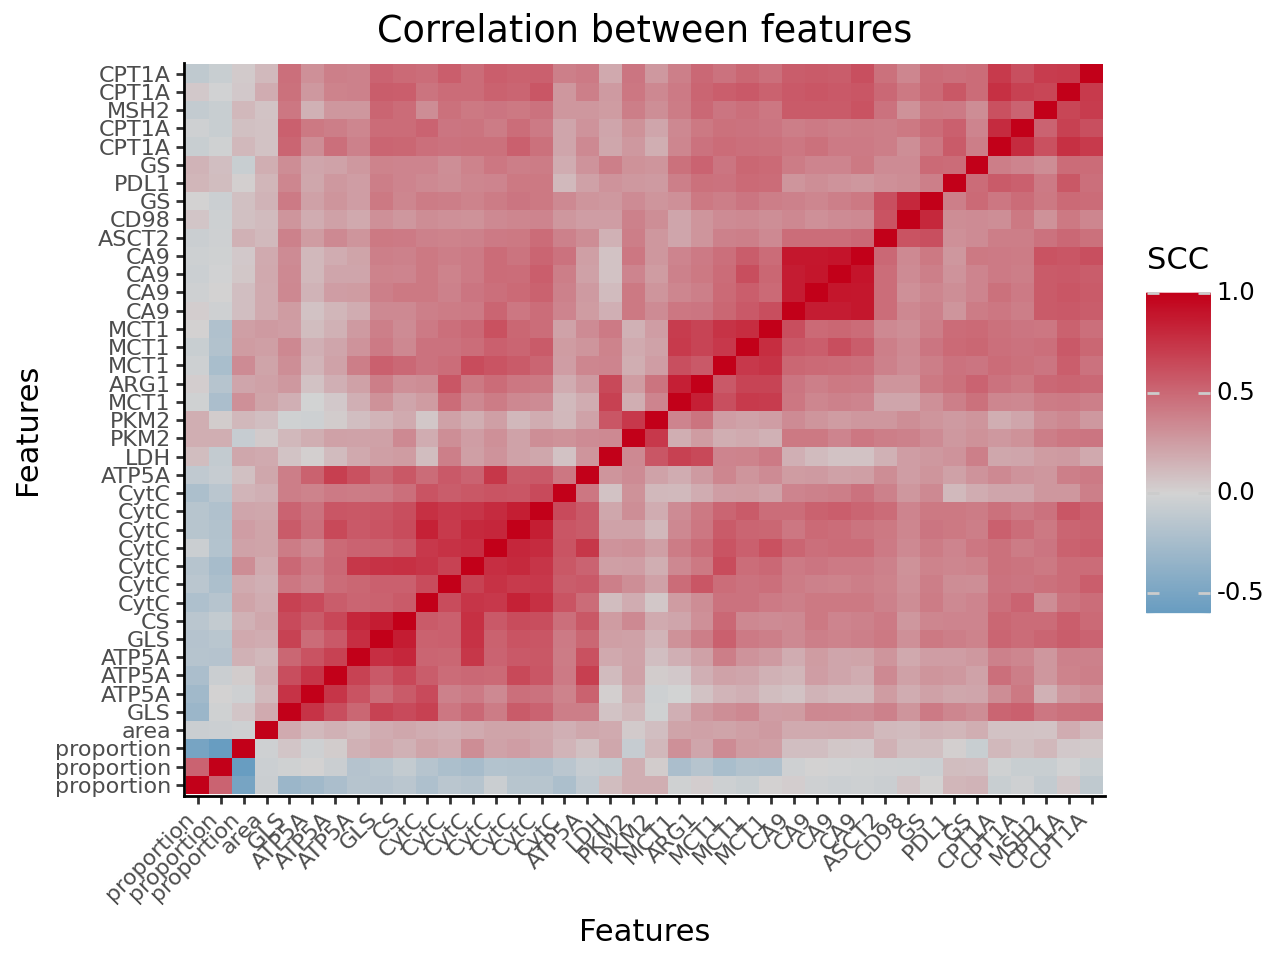

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 5.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig5/correlation_multicellular.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 5.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig5/correlation_multicellular.png


In [86]:
# Handle repeated Variable values by creating unique identifiers
original_names = features.var.Variable.tolist()
var_counts = {}
unique_names = []

for name in original_names:
    if name in var_counts:
        var_counts[name] += 1
        unique_names.append(f"{name}_{var_counts[name]}")
    else:
        var_counts[name] = 0
        unique_names.append(name)

# Update correlation matrix with unique names
cordf.index = unique_names
cordf.columns = unique_names

# Perform hierarchical clustering to reorder by similarity
row_linkage = linkage(cordf, method='complete')
col_linkage = linkage(cordf.T, method='complete')

# Get the order of rows and columns
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Get ordered variable names
ordered_unique_names_rows = [unique_names[i] for i in row_order]
ordered_unique_names_cols = [unique_names[i] for i in col_order]

# Melt the correlation matrix for plotting
cordf_melted = cordf.reset_index().melt(id_vars='index', var_name='Variable2', value_name='correlation')
cordf_melted.rename(columns={'index': 'Variable1'}, inplace=True)

# Convert to categorical with ordered levels
cordf_melted['Variable1'] = pd.Categorical(cordf_melted['Variable1'], 
                                          categories=ordered_unique_names_rows, 
                                          ordered=True)
cordf_melted['Variable2'] = pd.Categorical(cordf_melted['Variable2'], 
                                          categories=ordered_unique_names_cols, 
                                          ordered=True)

# Create mapping back to original names for labels
name_mapping = dict(zip(unique_names, original_names))

# Create the heatmap
plot = (ggplot(cordf_melted, aes(x='Variable1', y='Variable2', fill='correlation'))
        + geom_tile()
        + scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0)
        + scale_x_discrete(labels=name_mapping)  # Use original names for x-axis
        + scale_y_discrete(labels=name_mapping)  # Use original names for y-axis
        + theme_classic() 
        + theme(axis_text_x=element_text(angle=45, hjust=1, size=8),
                axis_text_y=element_text(size=8))
        + labs(title='Correlation between features',
               x='Features',
               y='Features',
               fill='SCC'))

print(plot)
ggsave(plot, "../../figures/fig5/correlation_multicellular.pdf", width = 6, height = 5.5)
ggsave(plot + theme(legend_position='bottom'), 
       "../../figures/fig5/correlation_multicellular.png", 
       width = 6, height = 5.5)

/tmp/ipykernel_267370/148939054.py:47: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


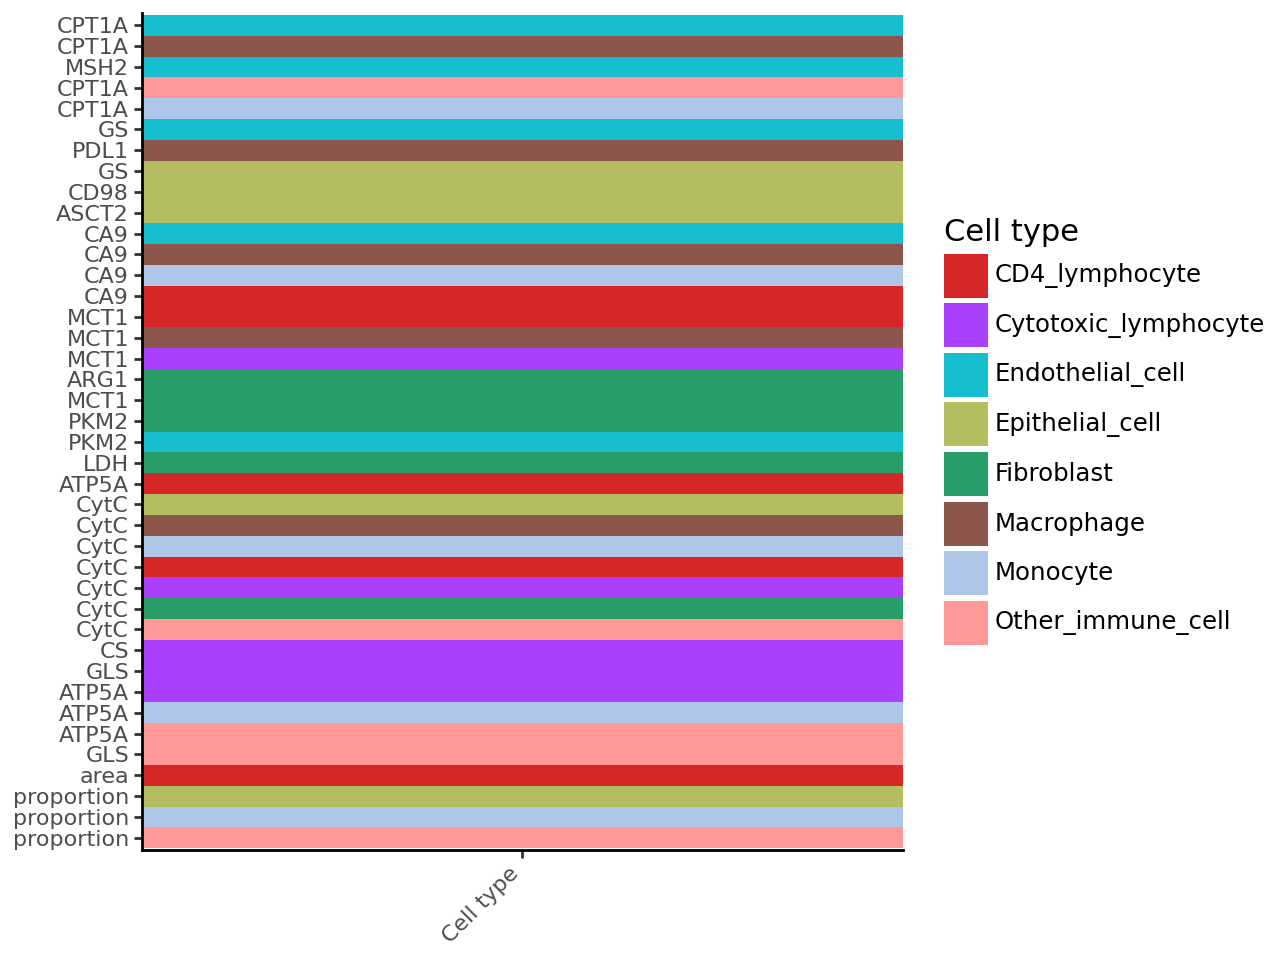

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.55 x 5.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig5/celltype_annotation.pdf


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig5/celltype_annotation_legend.pdf


In [84]:
# Cell type legend

celltype_color = {
    'Other_immune_cell': '#FF9896',
    'Cytotoxic_lymphocyte': '#AA40FC',
    'Monocyte': '#AEC7E8',
    'Macrophage': '#8C564B',
    'CD4_lymphocyte': '#D62728',
    'Fibroblast': '#279E68',
    'Epithelial_cell': '#B5BD61',
    'Endothelial_cell': '#17BECF'
}

# Create cell type annotation data
celltype_data = []
for unique_name in ordered_unique_names_rows:
    # Find the original index for this unique name
    original_idx = unique_names.index(unique_name)
    original_name = original_names[original_idx]
    cell_type = features.var["Cell type"].iloc[original_idx]
    
    celltype_data.append({
        'Variable': unique_name,
        'Annotation': 'Cell type',
        'Cell_type': cell_type
    })

celltype_df = pd.DataFrame(celltype_data)

# Convert Variable to categorical with the same ordering as correlation heatmap
celltype_df['Variable'] = pd.Categorical(celltype_df['Variable'], 
                                        categories=ordered_unique_names_rows, 
                                        ordered=True)

# Create the cell type annotation heatmap
celltype_plot = (ggplot(celltype_df, aes(x='Annotation', y='Variable', fill='Cell_type'))
                + geom_tile()
                + scale_fill_manual(values=celltype_color)
                + scale_y_discrete(labels=name_mapping)  # Use original names for y-axis
                + theme_classic()
                + theme(axis_text_x=element_text(angle=45, hjust=1, size=8),
                        axis_title_y=element_blank(),
                        axis_title_x=element_blank(),
                        axis_text_y=element_text(size=8))
                + labs(fill='Cell type'))

print(celltype_plot)
ggsave(celltype_plot, "../../figures/fig5/celltype_annotation.pdf", width = 2.55, height = 5.5)
ggsave(celltype_plot + theme(legend_position='bottom'), "../../figures/fig5/celltype_annotation_legend.pdf", 
       width = 7, height = 5.5)